# import packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.signal import convolve
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import fftn, fftshift
import dask.array as da
%matplotlib widget

# import local files

In [2]:
from ptable_dict import ptable, atomic_masses
from utilities import write_xyz, load_xyz, rotation_matrix, gaussian_kernel
from meshgrids import generate_density_grid, convert_grid_qspace, plot_3D_grid
from detector import make_detector, rotate_about_normal, rotate_about_horizontal, rotate_about_vertical, intersect_detector

# Generate and plot electron density voxel map for given xyz file

In [3]:
%%time
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/forward_sim/'
xyz_path = f'{dirr}test_xyz_files/Benzene.xyz'
sigma = 1
voxel_size = 0.1
dens_grid, x_axis, y_axis, z_axis = generate_density_grid(xyz_path, sigma, voxel_size)

CPU times: user 33.8 ms, sys: 7.19 ms, total: 41 ms
Wall time: 41.3 ms


In [ ]:
%%time
test = dens_grid.compute()

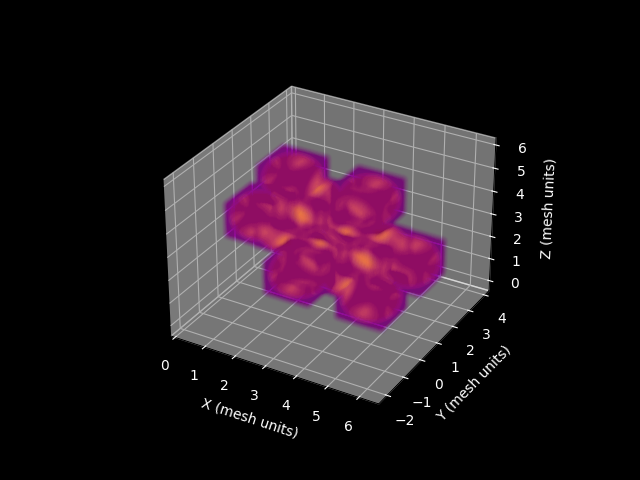

In [6]:
threshold = 80
num_levels=20
cmap = 'plasma'
plot_3D_grid(test, x_axis, y_axis, z_axis, cmap, threshold, num_levels)

# Generate and plot electron density reciprocal space voxel map for given xyz file

In [ ]:
iq, qx, qy, qz = convert_grid_qspace(dens_grid, x_mesh, y_mesh, z_mesh)
threshold = 99
num_levels=30
cmap = 'plasma'
# plot_3D_grid(iq, qx, qy, qz, cmap, threshold, num_levels)

# find q-resolutions

In [ ]:
x_vals = qx[0,:,0]
y_vals = qy[:,0,0]
z_vals = qz[0,0,:]
qx_res = x_vals[1]-x_vals[0]
qy_res = y_vals[1]-y_vals[0]
qz_res = z_vals[1]-z_vals[0]
print(f'Resolutions are [qx={qx_res:.4f}, qy={qy_res:.4f}, qz={qz_res:.4f}]')

# Set up Detector

In [ ]:
det_pixels = (200,200) #horizontal, vertical
det_qs = (15,15) #horizontal, vertical (these are absolute maximums. detector centered at 0)
det_x_grid, det_y_grid, det_z_grid, det_h, det_v = make_detector(det_qs[0], det_pixels[0], det_qs[1], det_pixels[1])


# Rotate detector

In [ ]:
psi = 0 #rotation in degrees of detector about detector normal axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_normal(det_x_grid, det_y_grid, det_z_grid, psi)

In [ ]:
phi = 90 #rotation in degrees of detector about detector vertical axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_vertical(det_x_grid, det_y_grid, det_z_grid, phi)

In [ ]:
theta = 0 #rotation in degrees of detector about detector horizontal axis
det_x_grid, det_y_grid, det_z_grid = rotate_about_vertical(det_x_grid, det_y_grid, det_z_grid, theta)

In [ ]:
det_ints = intersect_detector(iq, qx, qy, qz, det_x_grid, det_y_grid, det_z_grid, det_h, det_v)

# plot
fig, ax1 = subplots()
ax1.imshow(np.log(det_ints),
           norm=matplotlib.colors.Normalize(),
           extent=(np.min(det_h),np.max(det_h),np.min(det_v),np.max(det_v)),
           cmap='turbo',
           origin = 'lower')
ax1.set_xlabel('qxy')
ax1.set_ylabel('qz')

In [ ]:
import numpy as np
import dask.array as da
from dask.array.fft import fftn, ifftn
from scipy.fft import fftshift
from dask_image.ndfilters import convolve

def generate_density_grid(xyz_path, sigma, voxel_size):
    """
    Generates a 3D voxelized electron density grid from .xyz file using Dask. 
    Electron density is smeared using gaussian convolution with width sigma. 
    Smearing is skipped if sigma=0.
    
    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - sigma: peak width where FWHM=2 sqrt(2ln(2))sigma. Set to 0 for no smearing
    
    Returns:
    - density_grid: 3D meshgrid of electron density values
    - x_mesh: 3D meshgrid of x coordinate values 
    - y_mesh: 3D meshgrid of y coordinate values 
    - z_mesh: 3D meshgrid of z coordinate values 
    """
    # Extracting the atomic symbols and positions from the xyz file
    coords, symbols = load_xyz(xyz_path)

    # Shift coords array to origin (buffer ensures room for Gaussian smearing)
    coords = np.array(coords)
    buffer = 3 * sigma # same size as Gaussian kernel (made later)
    coords[:, 0] -= np.min(coords[:, 0]) - buffer
    coords[:, 1] -= np.min(coords[:, 1]) - buffer
    coords[:, 2] -= np.min(coords[:, 2]) - buffer

    # Axis grids
    grid_size_x = int(np.ceil((np.max(coords[:, 0]) + buffer) / voxel_size))
    grid_size_y = int(np.ceil((np.max(coords[:, 1]) + buffer) / voxel_size))
    grid_size_z = int(np.ceil((np.max(coords[:, 2]) + buffer) / voxel_size))
    x_axis = np.linspace(0, grid_size_x * voxel_size, grid_size_x)
    y_axis = np.linspace(0, grid_size_y * voxel_size, grid_size_y)
    z_axis = np.linspace(0, grid_size_z * voxel_size, grid_size_z)

    #create dask meshgrids
    x_mesh, y_mesh, z_mesh = da.meshgrid(x_axis, y_axis, z_axis)

    # Create an empty grid with Dask
    density_grid = da.zeros_like(x_mesh)

    # Populate the grid
    for coord, symbol in zip(coords, symbols):
        grid_coord = (coord / voxel_size).astype(int)
        density_grid[grid_coord[1], grid_coord[0], grid_coord[2]] += ptable[symbol] * voxel_size ** 3

    # Create a Gaussian kernel
    if sigma:
        sigma_voxel = sigma/voxel_size
        kernel_size = 6 * sigma_voxel + 1  # Ensure the kernel size covers enough of the Gaussian
        gaussian_kernel_3d = gaussian_kernel(kernel_size, sigma_voxel)
        # Convolve using dask_image.ndfilters.convolve
        density_grid = convolve(density_grid, gaussian_kernel_3d)

    # Compute the result
    # density_grid = density_grid.compute()
    # x_mesh = x_mesh.compute()
    # y_mesh = y_mesh.compute()
    # z_mesh = z_mesh.compute()

    return density_grid, x_mesh, y_mesh, z_mesh
